# Initialize Packages

In [3]:
%pip install pandas matplotlib seaborn scikit-learn --quiet

Note: you may need to restart the kernel to use updated packages.



[notice] A new release of pip is available: 25.1.1 -> 25.3
[notice] To update, run: python.exe -m pip install --upgrade pip


In [4]:
# Imports for ML tasks
# Ensure xgboost is installed in this notebook environment (fixes "Import could not be resolved")
%pip install xgboost --quiet
%matplotlib inline
import warnings
warnings.filterwarnings('ignore')

# Data & numerical
import numpy as np
import pandas as pd

# Visualization
import matplotlib.pyplot as plt
import seaborn as sns
sns.set_style('whitegrid')

# Preprocessing & model selection
from sklearn.model_selection import train_test_split, GridSearchCV, cross_val_score
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.impute import SimpleImputer
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer

# Models
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression

# Evaluation
from sklearn.metrics import (
    accuracy_score, precision_score, recall_score,
    f1_score, roc_auc_score, confusion_matrix, classification_report
)

# Optional - try to import if available
try:
    import xgboost as xgb
except Exception:
    xgb = None

# Print key library versions for reproducibility
print(f"numpy={np.__version__}, pandas={pd.__version__}, scikit-learn={__import__('sklearn').__version__}, matplotlib={__import__('matplotlib').__version__}, seaborn={sns.__version__}")


[notice] A new release of pip is available: 25.1.1 -> 25.3
[notice] To update, run: python.exe -m pip install --upgrade pip


Note: you may need to restart the kernel to use updated packages.
numpy=2.4.0, pandas=2.3.3, scikit-learn=1.8.0, matplotlib=3.10.8, seaborn=0.13.2


# Initialize Datasets

In [5]:
train_data = pd.read_csv("titanic_train.csv")
test_data = pd.read_csv("titanic_test.csv")

columns_to_drop = ["Name", "Cabin", "Ticket"]
train_data = train_data.drop(columns=columns_to_drop, errors='ignore')
test_data = test_data.drop(columns=columns_to_drop, errors='ignore')

In [6]:
# Impute missing fare
train_data = train_data.replace({"Fare": np.nan}, train_data["Fare"].median())
test_data = test_data.replace({"Fare": np.nan}, test_data["Fare"].median())

# Impute missing ages
age_imputer = SimpleImputer(strategy='median')
train_data['Age'] = age_imputer.fit_transform(train_data[['Age']])
test_data['Age'] = age_imputer.transform(test_data[['Age']])

# Drop remaining missing values
train_data = train_data.dropna()
test_data = test_data.dropna()

In [7]:
# Custom mappings for non-numeric columns (edit values as you prefer)
sex_mappings = {
    'male': 0, 'female': 1
}

embarked_mappings = {
    'S': 0, 
    'C': 1, 
    'Q': 2
}

train_data["Sex"] = train_data["Sex"].map(sex_mappings)
test_data["Sex"] = test_data["Sex"].map(sex_mappings)

train_data["Embarked"] = train_data["Embarked"].map(embarked_mappings)
test_data["Embarked"] = test_data["Embarked"].map(embarked_mappings)

In [8]:
# Create 'Adult' column: 0 if Age < 12 else 1 (preserve NA as nullable integer)
def make_adult_col(age_series):
    return age_series.apply(lambda x: pd.NA if pd.isna(x) else (0 if x < 12 else 1)).astype('Int64')

if 'train_data' in globals():
    train_data['Adult'] = make_adult_col(train_data['Age'])
    print("train_data 'Adult' value counts:")
    print(train_data['Adult'].value_counts(dropna=False).to_string())

if 'test_data' in globals():
    test_data['Adult'] = make_adult_col(test_data['Age'])
    print("test_data 'Adult' value counts:")
    print(test_data['Adult'].value_counts(dropna=False).to_string())

train_data 'Adult' value counts:
Adult
1    821
0     68
test_data 'Adult' value counts:
Adult
1    395
0     23


In [9]:
train_data.columns

Index(['PassengerId', 'Survived', 'Pclass', 'Sex', 'Age', 'SibSp', 'Parch',
       'Fare', 'Embarked', 'Adult'],
      dtype='object')

In [10]:
X_columns = [col for col in train_data.columns if col != 'Survived']
y_column = 'Survived'

X_train = train_data[X_columns]
y_train = train_data[y_column]
X_test = test_data[X_columns]
# y_test = test_data[y_column]

X_train, X_val, y_train, y_val = train_test_split(X_train, y_train, test_size=0.2, random_state=42)

# Random Forest

In [11]:
%pip install optuna -q

Note: you may need to restart the kernel to use updated packages.



[notice] A new release of pip is available: 25.1.1 -> 25.3
[notice] To update, run: python.exe -m pip install --upgrade pip


In [34]:
import optuna
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import cross_val_score

def objective(trial):
    params = {
        'n_estimators': trial.suggest_int('n_estimators', 100, 1000),
        'max_depth': trial.suggest_int('max_depth', 3, 30),
        'max_features': trial.suggest_categorical('max_features', ['sqrt', 'log2', 0.2, 0.5]),
        'min_samples_split': trial.suggest_int('min_samples_split', 2, 20),
        'min_samples_leaf': trial.suggest_int('min_samples_leaf', 1, 10),
        'bootstrap': trial.suggest_categorical('bootstrap', [True, False]),
        'criterion': trial.suggest_categorical('criterion', ['gini', 'entropy']),
        'random_state': 42,
    }
    clf = RandomForestClassifier(**params, n_jobs=-1)
    # Use n_jobs=1 in cross_val_score to avoid nested parallelism
    return cross_val_score(clf, X_train, y_train, cv=5, scoring='roc_auc', n_jobs=1).mean()

study = optuna.create_study(direction='maximize', sampler=optuna.samplers.TPESampler(seed=42))
study.optimize(objective, n_trials=100, n_jobs=1)
print('Best params:', study.best_params)

[I 2025-12-30 01:19:34,371] A new study created in memory with name: no-name-4cd73be5-ddf7-472c-af07-b47f831053f4
[I 2025-12-30 01:19:37,352] Trial 0 finished with value: 0.8793526170798899 and parameters: {'n_estimators': 437, 'max_depth': 29, 'max_features': 'sqrt', 'min_samples_split': 3, 'min_samples_leaf': 9, 'bootstrap': False, 'criterion': 'entropy'}. Best is trial 0 with value: 0.8793526170798899.
[I 2025-12-30 01:19:44,426] Trial 1 finished with value: 0.8758027242118152 and parameters: {'n_estimators': 850, 'max_depth': 8, 'max_features': 0.5, 'min_samples_split': 10, 'min_samples_leaf': 3, 'bootstrap': True, 'criterion': 'entropy'}. Best is trial 0 with value: 0.8793526170798899.
[I 2025-12-30 01:19:47,545] Trial 2 finished with value: 0.8799204162840526 and parameters: {'n_estimators': 510, 'max_depth': 24, 'max_features': 0.2, 'min_samples_split': 13, 'min_samples_leaf': 2, 'bootstrap': False, 'criterion': 'gini'}. Best is trial 2 with value: 0.8799204162840526.
[I 2025-12

Best params: {'n_estimators': 644, 'max_depth': 23, 'max_features': 'log2', 'min_samples_split': 18, 'min_samples_leaf': 4, 'bootstrap': False, 'criterion': 'gini'}


In [16]:
# Train and evaluate RandomForest with the provided best parameters
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import classification_report, confusion_matrix, roc_auc_score

best_params = {
    'n_estimators': 644,
    'max_depth': 23,
    'max_features': 'log2',
    'min_samples_split': 18,
    'min_samples_leaf': 4,
    'bootstrap': False,
    'criterion': 'gini',
    'random_state': 32,
}

clf = RandomForestClassifier(**best_params, n_jobs=-1)
clf.fit(X_train, y_train)

# Threshold
threshold = 0.65

for name, X, y in [('Train', X_train, y_train), ('Validation', X_val, y_val)]:
    y_proba = clf.predict_proba(X)[:, 1] if hasattr(clf, 'predict_proba') else None
    y_pred = (y_proba >= threshold).astype(int) if y_proba is not None else clf.predict(X)
    print(f"\n=== {name} set ===")
    print("Classification report:\n", classification_report(y, y_pred))
    print("Confusion matrix:\n", confusion_matrix(y, y_pred))
    if y_proba is not None:
        try:
            auc = roc_auc_score(y, y_proba)
            print(f"ROC AUC: {auc:.4f}")
        except Exception:
            pass


=== Train set ===
Classification report:
               precision    recall  f1-score   support

           0       0.84      0.98      0.91       440
           1       0.96      0.70      0.81       271

    accuracy                           0.88       711
   macro avg       0.90      0.84      0.86       711
weighted avg       0.89      0.88      0.87       711

Confusion matrix:
 [[433   7]
 [ 81 190]]
ROC AUC: 0.9747

=== Validation set ===
Classification report:
               precision    recall  f1-score   support

           0       0.82      0.94      0.87       109
           1       0.87      0.67      0.75        69

    accuracy                           0.83       178
   macro avg       0.84      0.80      0.81       178
weighted avg       0.84      0.83      0.83       178

Confusion matrix:
 [[102   7]
 [ 23  46]]
ROC AUC: 0.8458


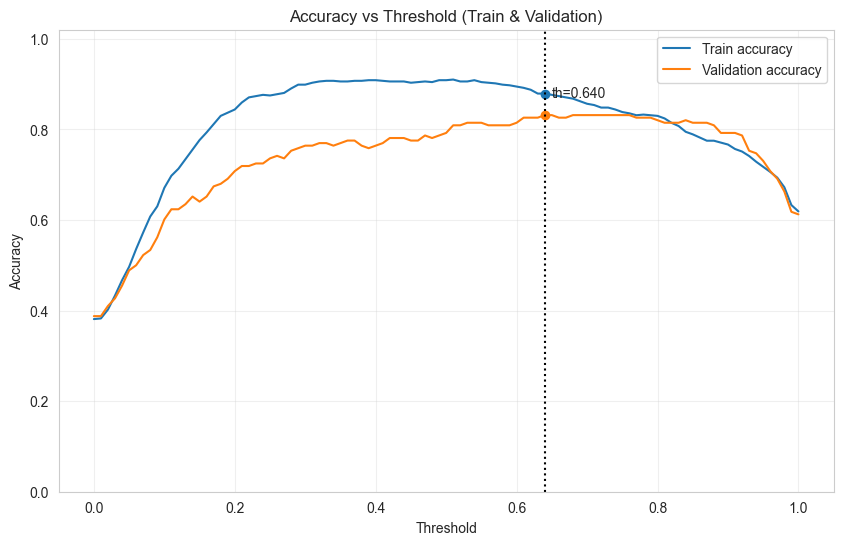

Best validation threshold: 0.640 — val_acc=0.831, train_acc=0.879


In [18]:
# Plot accuracy vs threshold for train and validation sets
import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics import accuracy_score

# Require predict_proba for threshold-based predictions
if not hasattr(clf, 'predict_proba'):
    raise RuntimeError("Model does not provide predicted probabilities (no predict_proba).")

# Predicted probabilities on train and validation sets
y_proba_train = clf.predict_proba(X_train)[:, 1]
y_proba_val = clf.predict_proba(X_val)[:, 1]
thresholds = np.linspace(0.0, 1.0, 101)

accs_train = []
accs_val = []
for t in thresholds:
    y_pred_train = (y_proba_train >= t).astype(int)
    y_pred_val = (y_proba_val >= t).astype(int)
    accs_train.append(accuracy_score(y_train, y_pred_train))
    accs_val.append(accuracy_score(y_val, y_pred_val))

accs_train = np.array(accs_train)
accs_val = np.array(accs_val)

# Choose threshold that maximizes validation accuracy (smallest threshold in ties)
best_idx = np.nanargmax(accs_val)
best_thresh = thresholds[best_idx]
best_train_acc = accs_train[best_idx]
best_val_acc = accs_val[best_idx]

# Plot
plt.figure(figsize=(10, 6))
plt.plot(thresholds, accs_train, label='Train accuracy', color='tab:blue')
plt.plot(thresholds, accs_val, label='Validation accuracy', color='tab:orange')
plt.axvline(best_thresh, color='k', linestyle=':', linewidth=1.5)  # dotted vertical line at best val threshold
# Mark best points
plt.scatter([best_thresh], [best_train_acc], color='tab:blue')
plt.scatter([best_thresh], [best_val_acc], color='tab:orange')
plt.text(best_thresh + 0.01, max(best_train_acc, best_val_acc), f'th={best_thresh:.3f}', va='center')

plt.xlabel('Threshold')
plt.ylabel('Accuracy')
plt.title('Accuracy vs Threshold (Train & Validation)')
plt.legend()
plt.grid(alpha=0.3)
plt.ylim(0, 1.02)
plt.show()

print(f'Best validation threshold: {best_thresh:.3f} — val_acc={best_val_acc:.3f}, train_acc={best_train_acc:.3f}')
threshold = float(best_thresh)

In [17]:
# Predict on the test set using the TRAIN-derived threshold when available, then export PassengerId and Survived
if 'clf' in globals() and 'X_test' in globals():
    # Predict probabilities when available
    if hasattr(clf, 'predict_proba'):
        proba = clf.predict_proba(X_test)[:, 1]
        test_data['Survived_proba'] = proba
        # Use threshold computed in the plotting cell if present, else default to 0.5
        th = globals().get('threshold', 0.5)
        preds = (proba >= th).astype(int)
        print(f"Using threshold={th:.3f} for prediction (from train set if available).")
    else:
        preds = clf.predict(X_test)

    test_data['Survived'] = preds.astype(int)

    # Ensure no duplicate/typo column remains
    if 'Survuved' in test_data.columns:
        test_data.drop(columns=['Survuved'], inplace=True)

    # Prepare export dataframe with PassengerId and Survived
    if 'PassengerId' in test_data.columns:
        export_df = test_data[['PassengerId', 'Survived']].copy()
    else:
        # Fallback: use index as PassengerId and warn
        print("Warning: 'PassengerId' not found in test_data; using dataframe index as PassengerId.")
        export_df = test_data[['Survived']].copy()
        export_df.insert(0, 'PassengerId', test_data.index)

    out_path = 'test_predictions_rf.csv'
    export_df.to_csv(out_path, index=False)

    print(f"Exported predictions to '{out_path}' with columns: {list(export_df.columns)}")
    print(export_df.head().to_string())
else:
    missing = [n for n in ('clf', 'X_test') if n not in globals()]
    print('Missing required objects:', ', '.join(missing))

Using threshold=0.650 for prediction (from train set if available).
Exported predictions to 'test_predictions_rf.csv' with columns: ['PassengerId', 'Survived']
   PassengerId  Survived
0          892         0
1          893         0
2          894         0
3          895         0
4          896         0


In [64]:
test_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 418 entries, 0 to 417
Data columns (total 12 columns):
 #   Column          Non-Null Count  Dtype  
---  ------          --------------  -----  
 0   PassengerId     418 non-null    int64  
 1   Pclass          418 non-null    int64  
 2   Sex             418 non-null    int64  
 3   Age             418 non-null    float64
 4   SibSp           418 non-null    int64  
 5   Parch           418 non-null    int64  
 6   Fare            418 non-null    float64
 7   Embarked        418 non-null    int64  
 8   Adult           418 non-null    Int64  
 9   Survived        418 non-null    int64  
 10  Survuved        418 non-null    int64  
 11  Survived_proba  418 non-null    float64
dtypes: Int64(1), float64(3), int64(8)
memory usage: 39.7 KB
